# Market Volatility Forecasting using GARCH models

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from scipy import stats

In [7]:
df = yf.download("FTSEMIB.MI")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-12-31,24402.000000,24402.000000,24402.000000,24402.000000,24402.000000,0
1998-01-02,24914.000000,24914.000000,24914.000000,24914.000000,24914.000000,0
1998-01-05,25734.000000,25734.000000,25734.000000,25734.000000,25734.000000,0
1998-01-06,25734.000000,25734.000000,25734.000000,25734.000000,25734.000000,0
1998-01-07,25961.000000,25961.000000,25961.000000,25961.000000,25961.000000,0
...,...,...,...,...,...,...
2023-12-07,30297.000000,30343.000000,30053.000000,30122.000000,30122.000000,421882000
2023-12-08,30150.000000,30427.000000,30058.000000,30404.000000,30404.000000,315888900
2023-12-11,30418.000000,30470.000000,30303.000000,30427.000000,30427.000000,309967400


In [8]:
returns = pd.Series(np.log(df['Adj Close']/df['Adj Close'].shift(1)), index = df.index).dropna()
returns 

Date
1998-01-02    0.020765
1998-01-05    0.032383
1998-01-06    0.000000
1998-01-07    0.008782
1998-01-08   -0.011078
                ...   
2023-12-07   -0.006750
2023-12-08    0.009318
2023-12-11    0.000756
2023-12-12   -0.002797
2023-12-13    0.001092
Name: Adj Close, Length: 6636, dtype: float64

## Volatility Clustering and Market Regimes

(-0.1, 0.1)

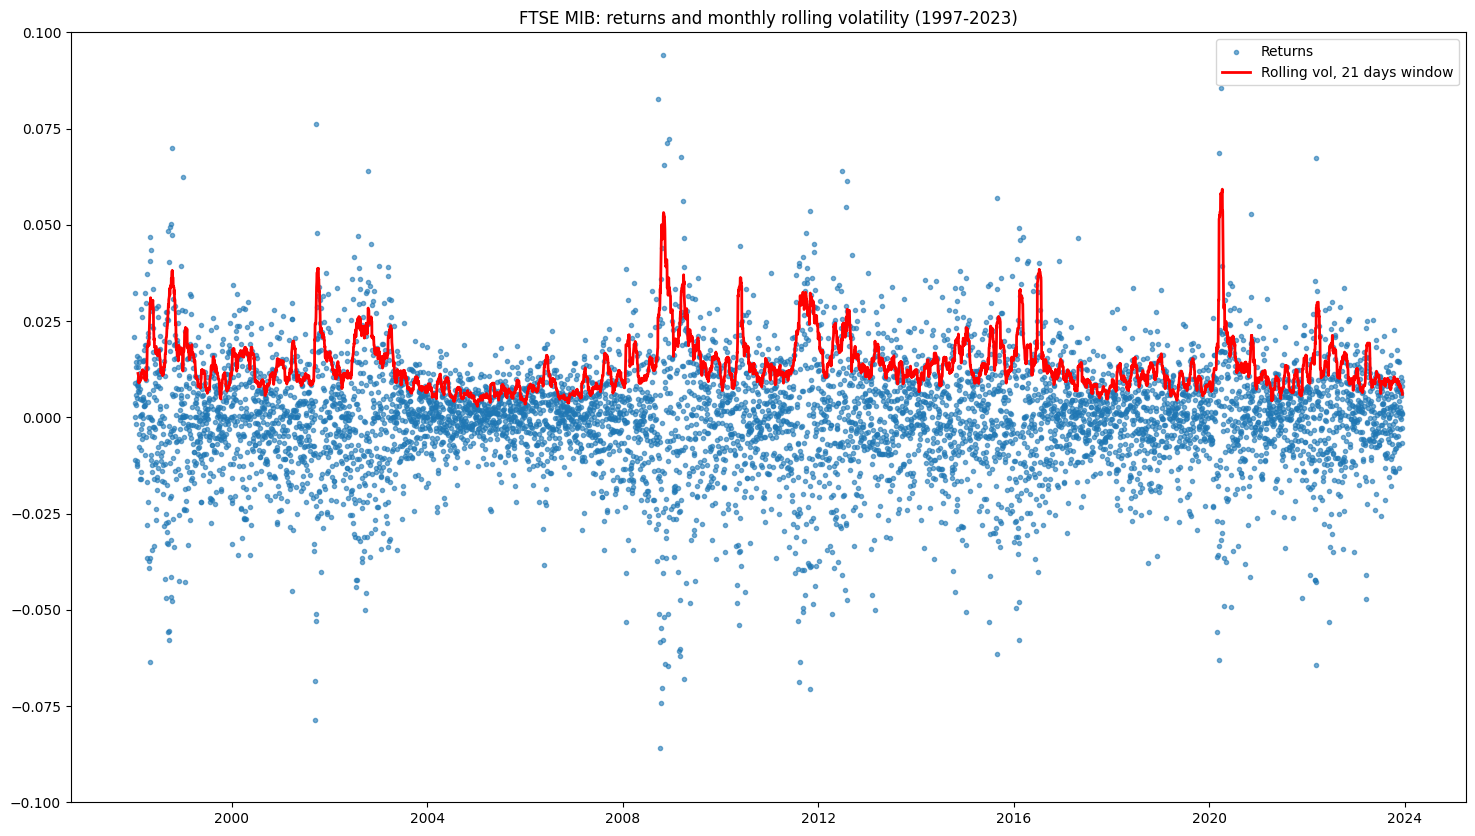

In [9]:
plt.figure(figsize=(18, 10))
plt.scatter(returns.index, returns, marker='.', label='Returns', alpha=0.6)

onem_vol = pd.Series(returns.rolling(window=21).std(), index = returns.index)
plt.plot(onem_vol, color='red', label='Rolling vol, 21 days window', linewidth=2)

plt.title('FTSE MIB: returns and monthly rolling volatility (1997-2023)')
plt.legend()
plt.ylim([-0.1, +0.1])

#### Volatility clustering

As we can see from this plot, is evident how there are alternating period in the behaviour of the returns (and its volatility). There is the persistence of periods in which the oscillations of the returns are more pronounced and cause a persistent increase in the volatility of the market. On the contrary, there are periods in which the market returns are more stable and tend to be associated with prolonged phases of constant volatility. 

These two arguments form the basis of the **volatility clustering** phenomenom. 

Volatility clustering refers to the observation that large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes. This phenomenom led during the 80s the development of new models that could be sensible and robust to this behaviour in the volatility: the ARCH and GARCH family of models. 

#### Market regimes

As we have understood, this periods of concentrated high volatility are tipycal of more general trends in the market: market regimes. But how we can observe these regimes? The following part of the notebook will try to showcase the presence of different regimes in the series of FTSE MIB by leveraging an unsupervised learning technique, KMEANS. 

### KMeans visualization of the Volatility clusters

In [10]:
from sklearn.cluster import KMeans
# let's recreate the series of rolling volatilities for 90 days (~3 months) days and annualize it 
x = np.sqrt(251) * pd.Series(returns.rolling(window=90).std().dropna())
x = x.to_frame()
x.rename(columns = {'Adj Close' : '90 days Rolling Vol'}, inplace=True)
x

,90 days Rolling Vol
Date,
1998-05-07,0.287886
1998-05-08,0.288404
1998-05-11,0.287192
1998-05-12,0.288669
1998-05-13,0.289694
...,...
2023-12-07,0.139079
2023-12-08,0.138854
2023-12-11,0.138625


In [11]:
def kmeans_cluster(x, n_clusters : int):
    kmeans = KMeans(n_clusters = n_clusters, n_init='auto')
    kmeans.fit(x) #fit the Kmeans algo to the data

    clusters = kmeans.predict(x)
    
    # 1) CREATE CLUSTER SERIES
    # The following series will store the cluster center of each element in the original series
    cluster_series = pd.Series(
        # creating a Series using list comprehension
        [
            round(kmeans.cluster_centers_[cluster_id, 0], 2) 
            for cluster_id in clusters
        ],
        index = x.index
    )

    # 2) CREATE CLUSTER DATAFRAME
    clustering_df = {}  #initialize an empty dictionary
    for cluster_id in range(n_clusters):
        # Extract the aproximated vol level of the cluster center (for each cluster)
        volatility_level = round(kmeans.cluster_centers_[cluster_id, 0], 2)  

        # For each cluster, store a boolean indicator for the observations that fall within the cluster 
        # -> the df is going to be a 3 column with each column referred to a cluster 
        # -> an observation in a specific row (time ordered series) will have TRUE(=1) for a column only if part of a cluster
        clustering_df[f'Cluster {volatility_level:.3}'] = (clusters == cluster_id).astype(float)
                                                                                # astype used to convert boolean in numeric
    
    clustering_df = pd.DataFrame(clustering_df, index=x.index) # convert list in a df
    clustering_df = clustering_df[sorted(clustering_df.columns)] # sort the columns of the df
    
    return clustering_df, cluster_series

1) `CREATE CLUSTER SERIES` 
    This piece of code is creating a series (with the same dimension as the x one), for each we'll have the cluster  reference for each element in the series. For each day, the value will indicate the cluster membership.

2) `CREATE CLUSTER DATAFRAME`
    This following part of the function is more difficult. Its main purpose it's extracting a dataframe in the format of a one hot encoding. The dataframe will have as many columns as the k defined at the beginning, and every element in the series will have a value = 1 if it belongs to a specific cluster, a specific column. 

In [12]:
KM_cluster_df, KM_cluster_series = kmeans_cluster(x, 3)
KM_cluster_df

,Cluster 0.15,Cluster 0.24,Cluster 0.39
Date,,,
1998-05-07,0.0,1.0,0.0
1998-05-08,0.0,1.0,0.0
1998-05-11,0.0,1.0,0.0
1998-05-12,0.0,1.0,0.0
1998-05-13,0.0,1.0,0.0
...,...,...,...
2023-12-07,1.0,0.0,0.0
2023-12-08,1.0,0.0,0.0
2023-12-11,1.0,0.0,0.0


#### Volatility clusters and 3 months rolling volatility

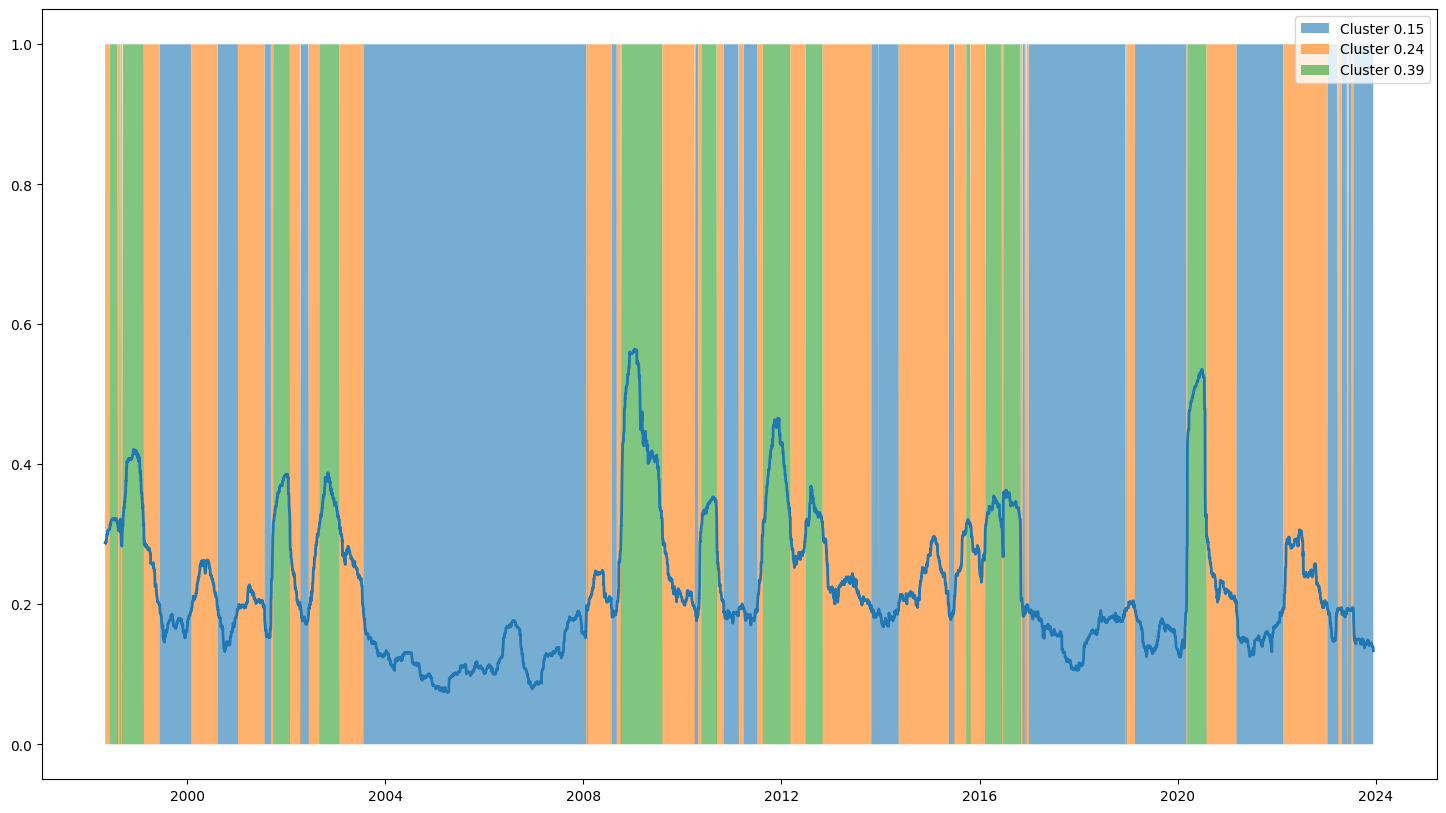

In [13]:
plt.figure(figsize=(18, 10))

for col in KM_cluster_df.columns:
    plt.fill_between(KM_cluster_df[col].index, 0, KM_cluster_df[col], alpha=0.6, label=col)

# plt.fill_between(KM_cluster_df['cluster 0.15'].index, 0, KM_cluster_df['cluster 0.15'], alpha=0.2, label='Cluster 0.15')
plt.plot(x, linewidth = 2)
plt.legend()

#### Volatility clusters and FTSE MIB PERFORMANCE

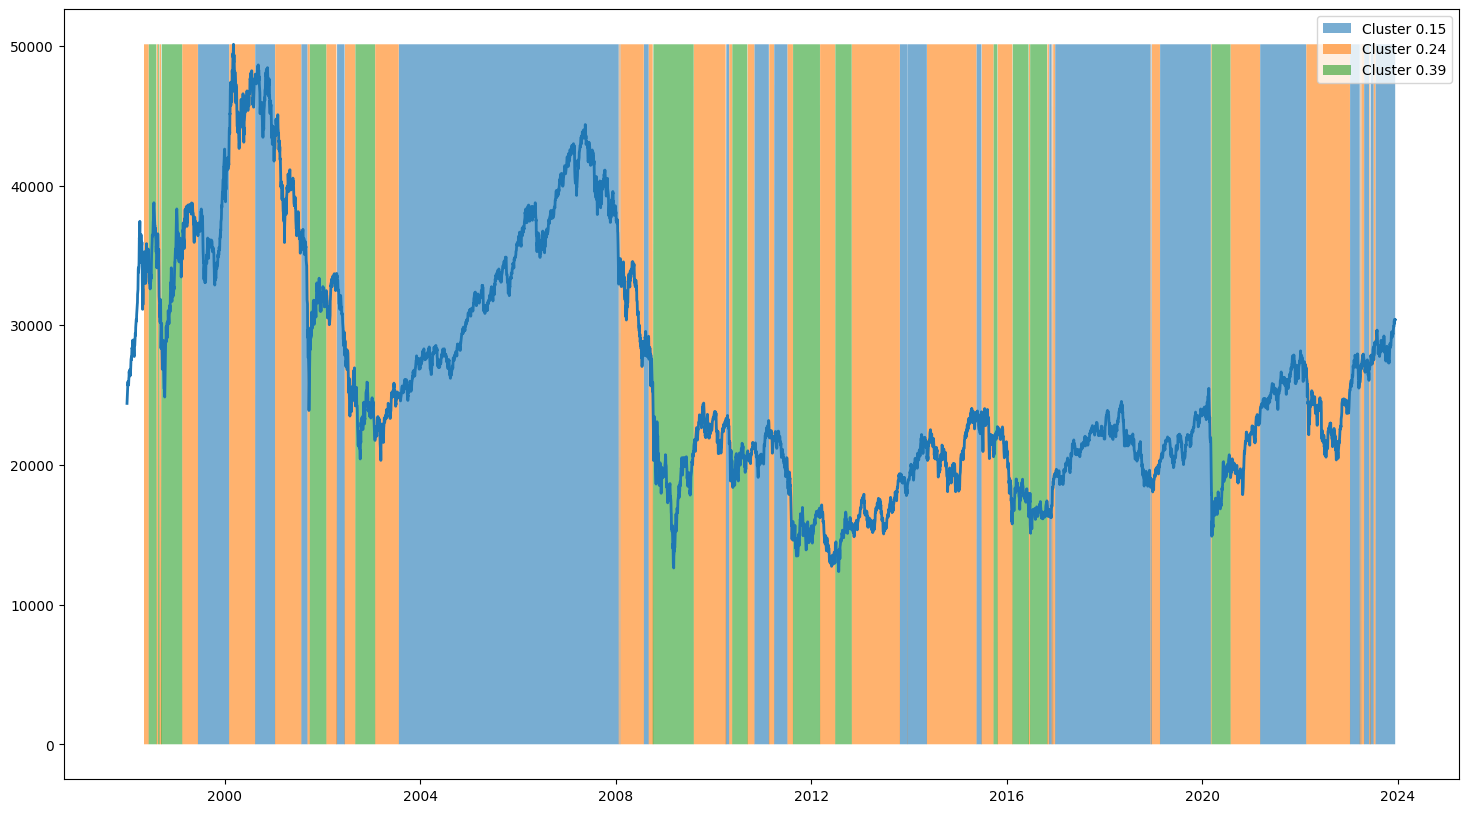

In [14]:

# Create a temporary dataframe for plotting purposes
temp = KM_cluster_df
for col in temp.columns:
    temp[col] = temp[col].apply(lambda x: x + max(df['Adj Close']) if x == 1 else x)


plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col].index, 0, temp[col], alpha=0.6, label=col)

plt.plot(df['Adj Close'], linewidth = 2)
plt.legend()

#### Volatility clusters and FTSE MIB PERFORMANCE (2008-2012)

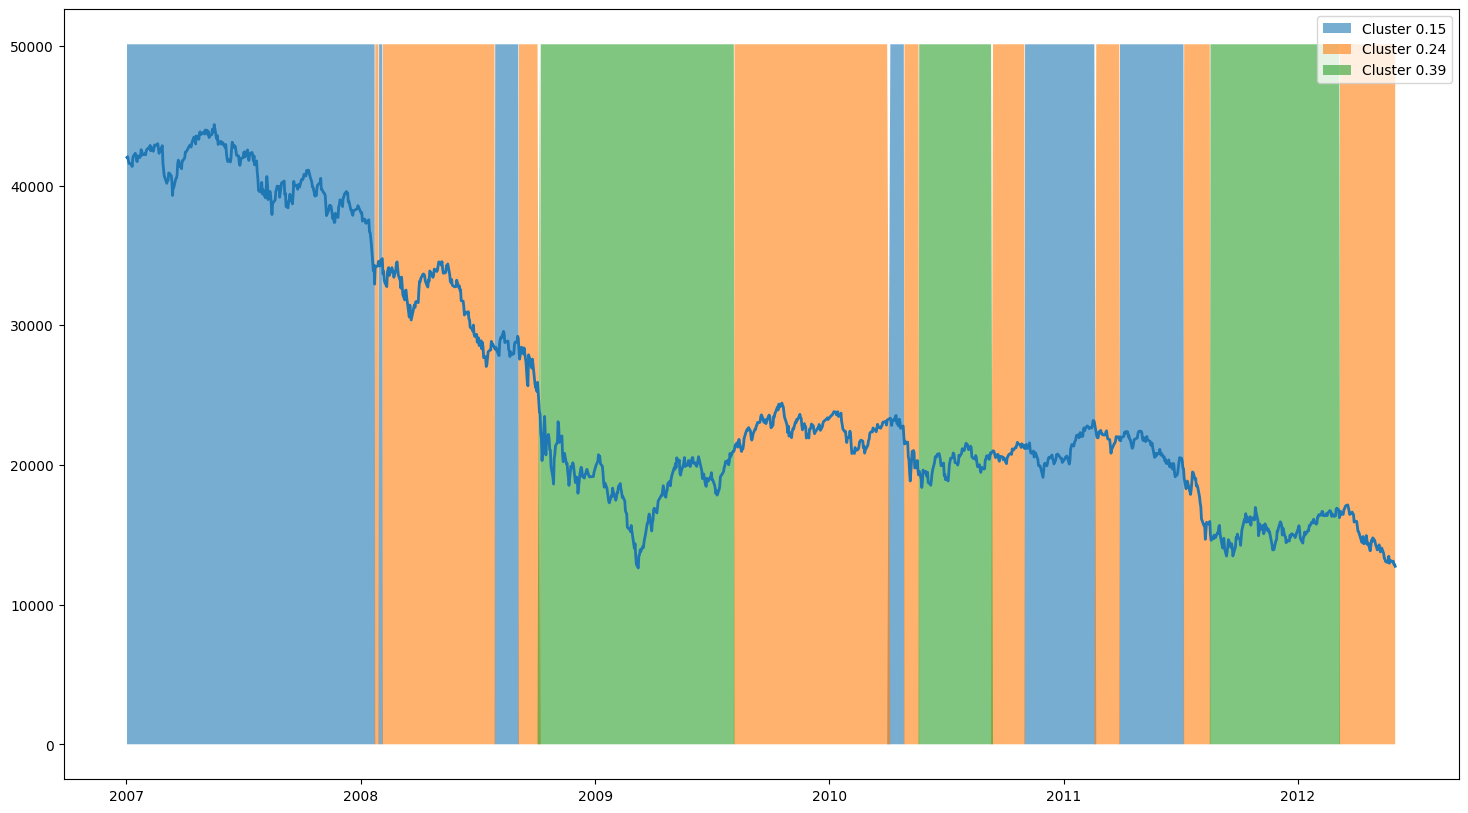

In [15]:
plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col]['2007-01-01' : '2012-06-01'].index, 0, temp[col]['2007-01-01' : '2012-06-01'], alpha=0.6, label=col)

plt.plot(df['Adj Close']['2007-01-01' : '2012-06-01'], linewidth = 2)
plt.legend()

As we can see from the plot above, the cluster with higher vol (0.49) is the one that characterized the 2008-2009 and part of the following debt crisis during 2011-2012. This periods are the  periods in which the markets is more stressed, there is a higher volatility, and returns are more probable in the extreme of the distribution (conditioned upon the specific market regimes we are considering). 
- The green areas belongs to the riskier market regime, with higher vol and extreme positive or negative returns. 
- The orange are are part of a less riskier market regime. 
- The blue areas belongs to a market regime in which the volatility is the lower between the three. 

#### Volatility distributions conditioned on Market Regimes

In [16]:
kde_plot_df = pd.concat([x, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_df.head()

,90 days Rolling Vol,Regimes
Date,,
1998-05-07,0.287886,0.24
1998-05-08,0.288404,0.24
1998-05-11,0.287192,0.24
1998-05-12,0.288669,0.24
1998-05-13,0.289694,0.24


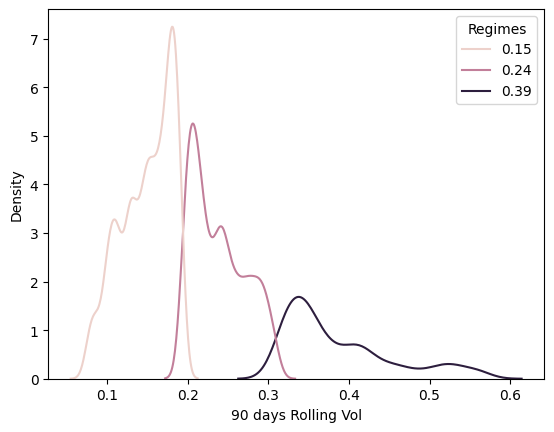

In [17]:
sns.kdeplot(kde_plot_df, x=kde_plot_df.columns[0], hue='Regimes')
plt.show()

This plot show the distribution of the volatily in the three different regimes we identified with the KMEANS. 

#### Volatility distributions conditioned on Market Regimes

We can also look at the distribution of the returns under the three different regimes. 

In [18]:
kde_plot_ret_df = pd.concat([returns, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_ret_df.rename(columns = {'Adj Close' : 'Returns'}, inplace=True) 
kde_plot_ret_df.dropna(inplace=True)
kde_plot_ret_df.head()


,Returns,Regimes
Date,,
1998-05-07,-0.009774,0.24
1998-05-08,0.023603,0.24
1998-05-11,0.027720,0.24
1998-05-12,-0.014282,0.24
1998-05-13,-0.012302,0.24


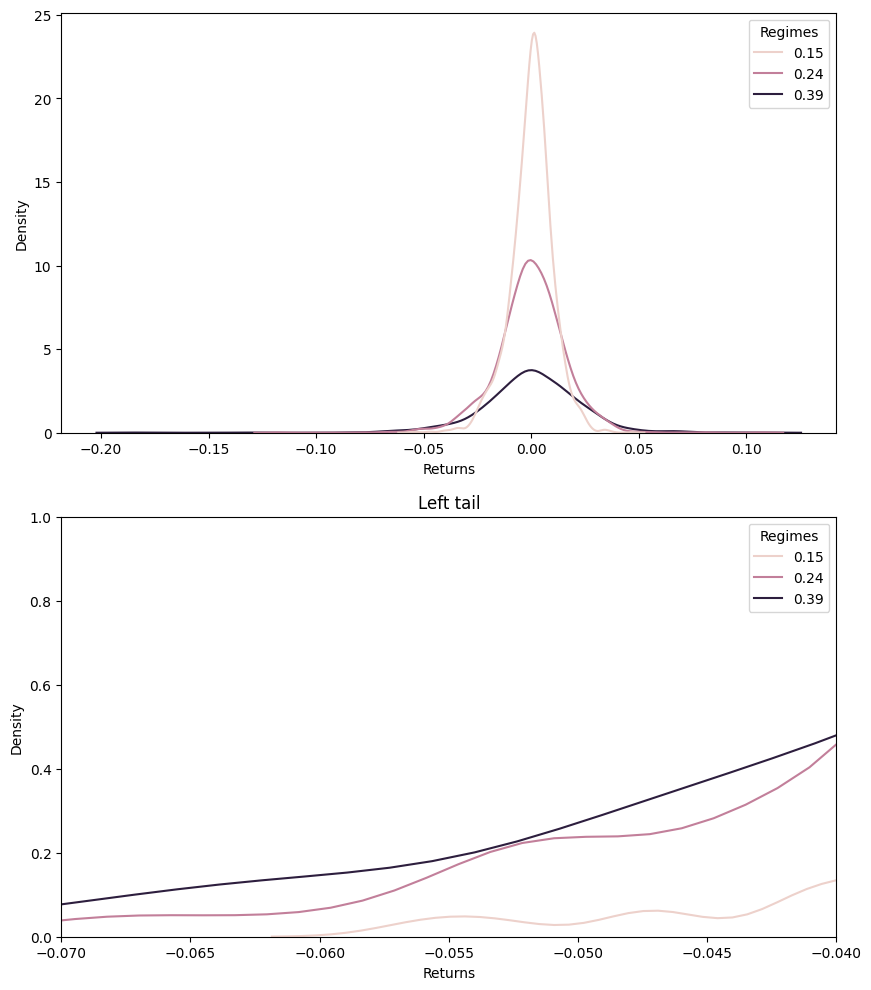

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))


sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[0])

sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[1])
axs[1].set_xlim([-0.07, -0.04])
axs[1].set_ylim([0, 1])
axs[1].set_title('Left tail')

plt.show()

As we can see in the market regime 3 (the one with higher volatility) the spike of the distribution is significantly lower, central returns (small movements in the market) are less probable to happen with respect to other market regimes. Instead, tails are clearly heavy and so extreme returns are more likely to happen. 

## Visualize FTSE MIB returns distribution and anomalies

Text(0.5, 1.0, '2nd anomaly: higher spike of FTSE returns distribution')

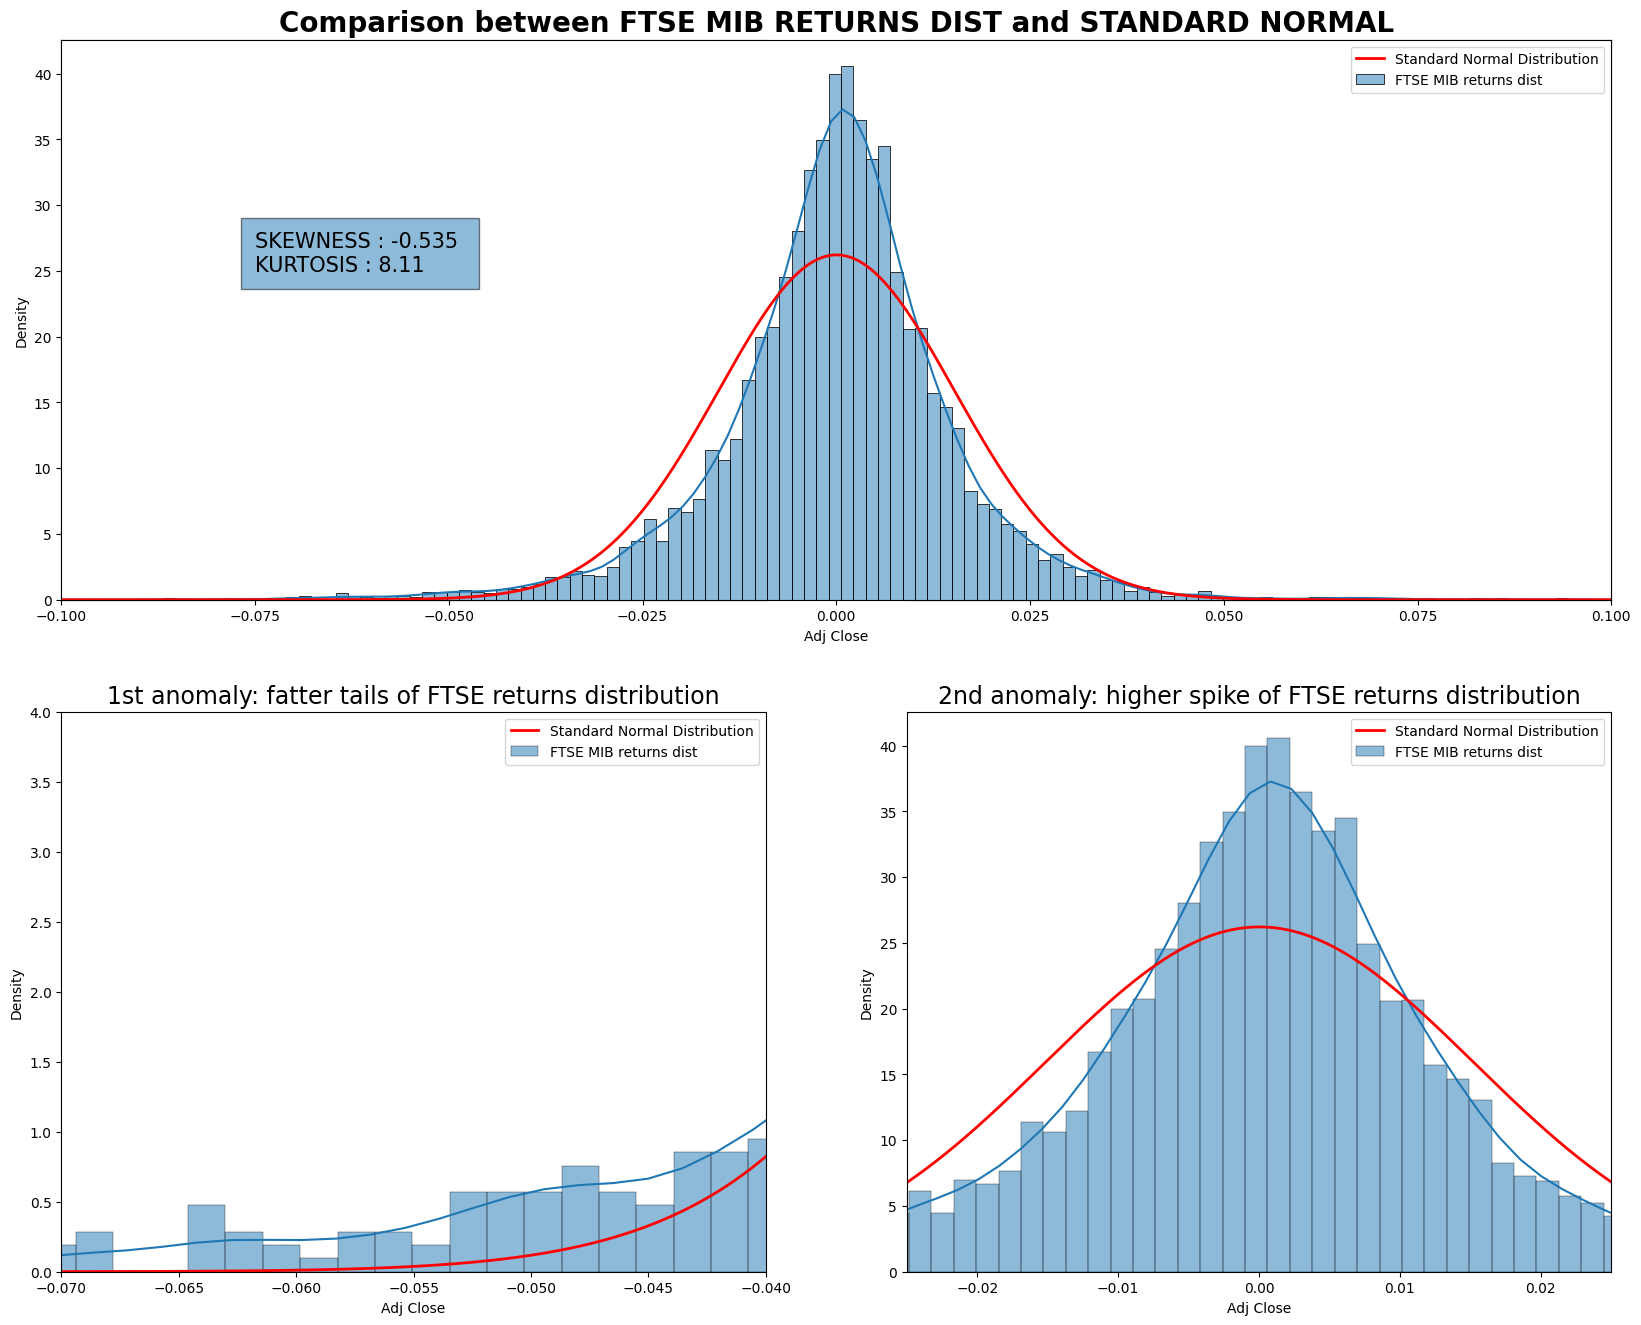

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])


sns.histplot(returns, stat='density', kde=True, label='FTSE MIB returns dist')
ax.set_xlim([-0.10, 0.10])
x = np.linspace(-0.1, 0.1, 1000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
ax.plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
ax.legend()
ax.set_title('Comparison between FTSE MIB RETURNS DIST and STANDARD NORMAL', fontsize=20, fontweight='bold')
ax.text(-0.075, 25, f'SKEWNESS : {returns.skew():.3} \nKURTOSIS : {returns.kurtosis():.3}', style='normal',
        bbox={'alpha': 0.5, 'pad': 10}, fontsize=15)

# Lower-left plot (focus on left fat tail)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 0], label='FTSE MIB returns dist')
axs[1, 0].set_xlim([-0.07, -0.04])
axs[1, 0].set_ylim([0, 4])
x = np.linspace(-0.07, -0.04, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 0].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 0].legend()
axs[1, 0].set_title('1st anomaly: fatter tails of FTSE returns distribution', fontsize=17)


# Lower-right plot (focus on the central leptokurticity)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 1], label='FTSE MIB returns dist')
axs[1, 1].set_xlim([-0.025, +0.025])
x = np.linspace(-0.025, +0.025, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 1].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 1].legend()
axs[1, 1].set_title('2nd anomaly: higher spike of FTSE returns distribution', fontsize=17)



In [22]:
print('Skewness:', returns.skew(), '\nKurtosis:', returns.kurtosis())

Skewness: -0.5352948261229868 
Kurtosis: 8.11337342982336


As we can observe from the previous plot and from the printe characteristichs of the distribution, there two main observations we can derive:

1) Kurtosis. The distribution of returns of the FTSE MIB present a clear leptokurticity, the high positive value for the kurtosis (+8.1) and the spikes in the central part of the distribution that we can visualize from the previous plot, confirms a typical behaviour in financial returns of the equity market. In addition, leptokurticity reflects another charactertics inthe distribution. The so called *fatter tails* (as shown in the lower left plot of the previous figure) implies that returns have a higher probability of extreme events (both positive and negative) compared to a normal distribution. This means that large price movements, both in the positive and negative tail, are more probable that what would be expected under the normal distribution assumption. 
This behaviour 

2) Skewness. The distribution of the returns presents a negative skewness. When compared to a normal distribution, this skewness suggests that the distribution of returns has a longer left tail. This is reflected in the fact that there is a higher probability of large negative returns comapred to large positive returns. This characeristic is important in the context of risk management, and analysing it can help the banks and financial institutions in choosing the right strategies to counter extreme negative events. 


This two characertistics are really important, and enter in the discussion of the *stylized facts of financial returns*. The other two remaining *facts* are the following:

3) The presence of a difference in the behavior of short term returns (such as daily) and long term returns (such as monthly or quarterly)

4) The tendency of extreme returns to happen in clusters, very closely in time (volatility clustering)

Naturally, this common characteristics have to be correctly modeled in order to capture the anomalies in the financial returns:

> *To model the characteristics of observed return distributions, approaches generally fall into one of three categories:*
> 1. *Assume that returns have stable distributions of infinite variance.*
> 2. *Assume that returns have distributions that are more fat-tailed and/or skewed than the normal distribution.*
> 3. *Assume that the distributions of returns are normal at each instant of time, but look fat tailed due to fluctuations in the variance(volatility) of these distributions. Incorporate the fluctuations in the volatility using ARCH/GARCH or other models.* 


        Ref: Portfolio Construction and Analytics, Frank J. Fabozzi, Wiley (2016), p.78

In the following notebook we are going to focus on the third assumption, by trying to model the fluctuations (and clusters) of the returns volatility, implementing various GARCH and GARCH derived models. 


## DATA PREPROCESSING

In order for the returns to be fed to the model, we should scale them by multiplying them by 100 (creating integer % values for the returns). 
This is a requirement of the `ARCH` library we are going to use to model GARCH models.


In [23]:
returns *= 100
returns[:10]

Date
1998-01-02    2.076480
1998-01-05    3.238318
1998-01-06    0.000000
1998-01-07    0.878234
1998-01-08   -1.107766
1998-01-09    0.380968
1998-01-12   -0.163094
1998-01-13    1.293529
1998-01-14    0.585256
1998-01-15    0.308460
Name: Adj Close, dtype: float64

## ARCH & GARCH Models Intuition

The ARCH model was the first heteroschedasticity-robust model. It was developed by Engle in 1982. 

The intutition of the model is that the integration of the autoregressive component of the variances should help to predict 
- Volatility as a weighted average of past information


#### GARCH
Intuitively, `GARCH` variance forecast can be interpreted as a weighted average of three different variance forecasts.

- The first is a constant variance that corresponds to the long run average.
- The second is the new information that was not available when the previous forecast was made.
- The third is the forecast that was made in the previous period.

The parameters associated to these three components determine how fast the variance changes with new information and how fast it reverts to its long run mean.


Since the GARCH is the the most complete model, this notebook will integrate it and extend the analysis to a couple of GARCH-derived models. 

### Implementing a GARCH(1, 1) Model

### CREATING CUSTOM FUNCTIONS FOR LATER USE

All this functions are going to be stored in the `utils.py` file, so that we can build a sort of library for this project. 

#### VOLATILITY ESTIMATORS

- **GARMAN KLASS FORMULA** (From the original paper)
    $$ \sigma_i = 0.511(u - d)^2 - 0.019\big[c(u + d) - 2ud \big]-0.383c^2$$  

    where:

    - $u = \log{\text{High}} - \log{\text{Open}}$
    - $d = \log{\text{Low}} - \log{\text{Open}}$
    - $c = \log{\text{Close}} - \log{\text{Open}}$

In [24]:
# ROLLING VOLATILITY
def rolling_vol(series, window, variance=False):

    vol = np.sqrt(pd.Series(series.rolling(window = window).std(), index = series.index))

    return vol

# EWMA VOLATILITY (from RiskMetric)
def EWMA_vol(series, lambda_=0.94):

    #LAMBDA=0.94 IS THE BEST CHOICE FOUND BY JPMORGAN RISK METRIC
    vol = series.ewm(alpha=lambda_, min_periods=1).std()

    return vol


## GARMAN KLASS ESTIMATOR
def GarmanKlass_vol(data : pd.DataFrame, sd=True):
    
    # Extract the series length
    n = len(data)
    
    # Extract the adjusting coefficient
    coeff = data['Adj Close'] / data['Close'] #adjusting coefficient
    
    # Adjust the high low open close 
    H = np.log(data['High'] * coeff)
    L = np.log(data['Low'] * coeff)
    O = np.log(data['Open'] * coeff)
    C = np.log(data['Close'] * coeff)
    
    # Calculate normalized returns
    u = H - O #between high and open
    d = L - O #between low and open
    c = C - O #between close and open
    
    ## Calculate the GK VARIANCE estimator
    x = 0.511 * (u - d)**2 + (-0.019) * (c * (u + d) - 2 * u * d) + (-0.383) * c**2
    
    # return the series
    return pd.Series(np.sqrt(x), index = data.index) 


#### PLOTTING FUNCTIONS

In [25]:
def plot_engine(vols, names):

    plt.figure(figsize=(14, 8))

    if vols.shape > 1:
        
        for v, name in zip(vols, names):
            plt.plot(v.index, v, label=f'{name} Volatility')
        
        plt.title('Comparison of ')

        plt.legend()
    
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.show()

## 1. GARCH(1, 1)

One of the first models we may want to try is the so GARCH(1, 1), widely used in the literature for modeling financial returns. 

